# An example of applying mSSA to the coefficients you created using pyEXP

This example assumes that you have run the `Part1-Coefficients` notebook to create the coefficients.

We begin by importing `pyEXP` and friends and setting the working directory.

In [1]:
import os
import yaml
import math
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

# In this test, I assume that you have already explored and run Part1-Coefficients. This notebook does some additional 
# analysis and plotting
#
os.chdir('../Data')

## Create the basis
This step is the same as in the previous notebook.  We are going to use the basis for field evaluation so we need the basis.

In [2]:
# Get the basis config
#
yaml_config = ""
with open('basis.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    yaml_config = yaml.dump(config)

# Construct the basis instance
#
basis = pyEXP.basis.Basis.factory(yaml_config)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.model>
---- Spherical::orthoTest: worst=0.00016446


So far, this is the same as in `Part1` . . . now:

## Reading the halo coefficients
We created the halo coefficients in the last notebook and stashed them in the EXP HDF5 format.  Now, we'll read them back.

In [3]:
# Reread the coefs from the file
#
coefs = pyEXP.coefs.Coefs.factory('test_coefs')

print("Got coefs for name=", coefs.getName())

Got coefs for name= dark halo


## Visualizing the fields
We made a few test grids in Part 1 of the notebook.  This time, we'll make surface renderings:

We now have the following [time field] pairs
----------------------------------------
  0.0100  azi force
  0.0100  dens
  0.0100  dens m=0
  0.0100  dens m>0
  0.0100  mer force
  0.0100  potl
  0.0100  potl m=0
  0.0100  potl m>0
  0.0100  rad force
----------------------------------------
  0.0200  azi force
  0.0200  dens
  0.0200  dens m=0
  0.0200  dens m>0
  0.0200  mer force
  0.0200  potl
  0.0200  potl m=0
  0.0200  potl m>0
  0.0200  rad force
----------------------------------------
  0.0300  azi force
  0.0300  dens
  0.0300  dens m=0
  0.0300  dens m>0
  0.0300  mer force
  0.0300  potl
  0.0300  potl m=0
  0.0300  potl m>0
  0.0300  rad force
----------------------------------------
  0.0400  azi force
  0.0400  dens
  0.0400  dens m=0
  0.0400  dens m>0
  0.0400  mer force
  0.0400  potl
  0.0400  potl m=0
  0.0400  potl m>0
  0.0400  rad force
----------------------------------------
  0.0500  azi force
  0.0500  dens
  0.0500  dens m=0
  0.0500  dens m>0
  0.0500  mer

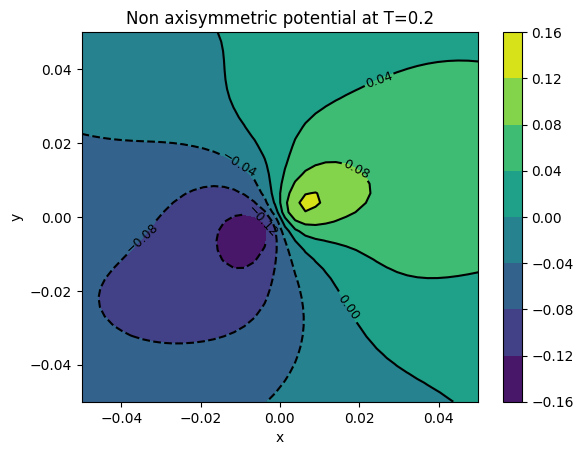

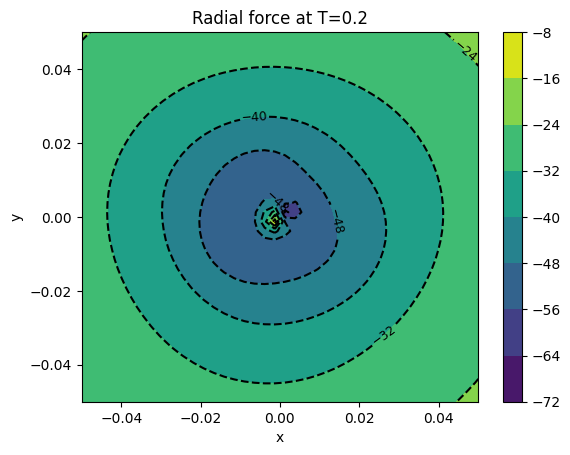

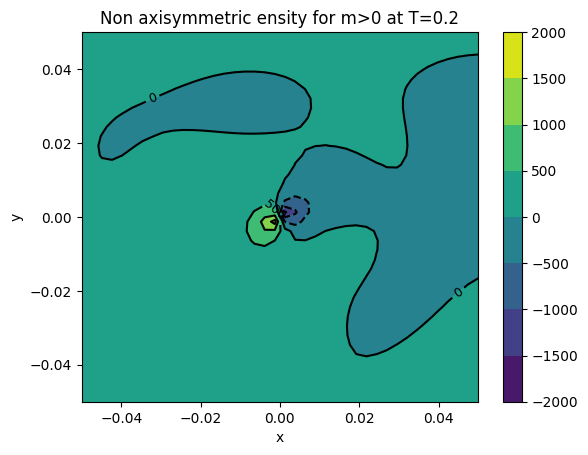

In [4]:
# Now try some slices for rendering
#
times = coefs.Times()
pmin  = [-0.05, -0.05, 0.0]
pmax  = [ 0.05,  0.05, 0.0]
grid  = [   40,    40,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

surfaces = fields.slices(basis, coefs)
print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v

# Print the potential image at the final time (I think there is a
# fencepost issue in this grid, no matter).
x = np.linspace(pmin[0], pmax[0], grid[0])
y = np.linspace(pmin[1], pmax[1], grid[1])
xv, yv = np.meshgrid(x, y)

# Visualize the final time slice in grid.  Obviously, we could use any 
# field we want.  Here is potential and radial force.

cont1 = plt.contour(xv, yv, surfaces[final]['potl m>0'], colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['potl m>0'])
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non axisymmetric potential at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['rad force'], colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['rad force'])
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['dens m>0'], colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['dens m>0'])
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non axisymmetric ensity for m>0 at T={}'.format(final))
plt.show()

### Using a point mesh instead of a grid

The `FieldGenerator` allows you to specify an array of Cartesian points for field evaluation.  This way, you can get creative with geometries and mesh spacing.  As an illustration, let us repeat the same renderings using this mesh-point method.

As a sanity check, let's do the same plots as the grid example above.

In [5]:
# First, we generate a Cartesian mesh
xy = np.linspace(-1, 1, 40)
mesh = np.ndarray((40*40, 3))
for i in range(40):
    for j in range(40):
        mesh[i*40+j, 0] = xy[i]
        mesh[i*40+j, 1] = xy[j]
        mesh[i*40+j, 2] = 0.0

Now that we have the a point set, in a Cartesian grid for this test, generate the points:

(40, 40)


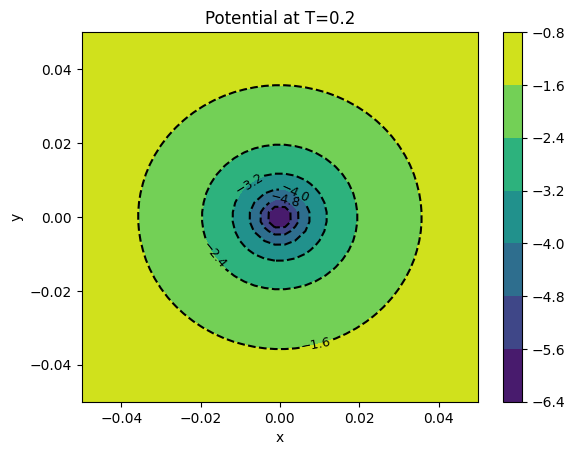

(40, 40)
(40, 40)


Text(0.5, 1.0, 'Density for m>0 at T=0.2')

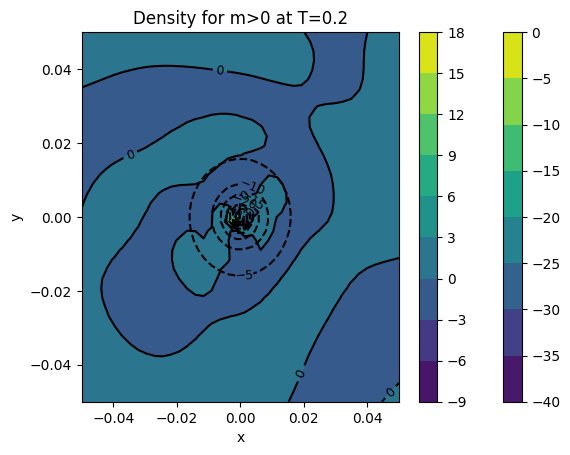

In [6]:
fields = pyEXP.field.FieldGenerator(times, mesh)

points = fields.points(basis, coefs)

# Print the potential image at the final time (I think there is a
# fencepost issue in this grid, no matter).
x = np.linspace(pmin[0], pmax[0], grid[0])
y = np.linspace(pmin[1], pmax[1], grid[1])
xv, yv = np.meshgrid(x, y)

def tomesh(points):
    ret = np.zeros(xv.shape)
    print(ret.shape)
    for i in range(40):
        for j in range(40):
            ret[i, j] = points[i*40+j]
    return ret

# Visualize the final time slice in grid.  Obviously, we could use any 
# field we want.  Here is potential and radial force.

img = tomesh(points[final]['potl'])
cont1 = plt.contour(xv, yv, img, colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, img)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential at T={}'.format(final))
plt.show()

img = tomesh(points[final]['rad force'])
cont1 = plt.contour(xv, yv, img, colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, img)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))

img = tomesh(points[final]['dens m>0'])
cont1 = plt.contour(xv, yv, img, colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, img)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Density for m>0 at T={}'.format(final))

### Now, let's take advantage of the unstructured point set for something different

First, let's make a point set on a spherical surface:

In [7]:
# First, we generate a Cartesian mesh
phi  = np.linspace(0.0, 2.0*math.pi, 40)
cost = np.linspace(-1.0, 1.0, 40)
mesh = np.ndarray((40*40, 3))
radius = 1.0
for i in range(40):
    for j in range(40):
        sint = np.sqrt(1.0 - cost[j]**2)
        mesh[i*40+j, 0] = radius*sint*math.cos(phi[i])
        mesh[i*40+j, 1] = radius*sint*math.sin(phi[i])
        mesh[i*40+j, 2] = radius*cost[j]

Generate a new point set for this unstructured grid as follows:

In [8]:
fields = pyEXP.field.FieldGenerator(times, mesh)
points = fields.points(basis, coefs)

Now, let's make a 3d scatter plot with points colored by field values:

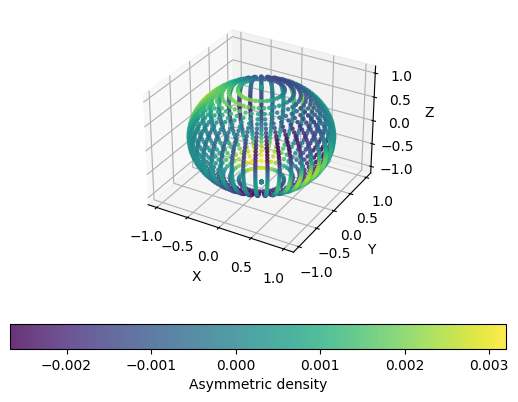

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2], c=points[times[-1]]['dens m>0'], marker='o', s=5, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.colorbar(sc, label='Asymmetric density', orientation='horizontal')
plt.show()

## Using MSSA
Generate the initial MSSA analyis and plot the run of eigenvalues

Keys= [[2, 0, 0], [2, 0, 1], [2, 0, 2], [2, 0, 3], [2, 0, 4], [2, 0, 5], [2, 0, 6], [2, 0, 7], [2, 0, 8], [2, 0, 9], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 1, 5], [2, 1, 6], [2, 1, 7], [2, 1, 8], [2, 1, 9], [2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 2, 5], [2, 2, 6], [2, 2, 7], [2, 2, 8], [2, 2, 9]]
Window=10 PC number=10
---- Eigen is using 4 threads
shape U = 500 x 11
shape Y = 11 x 500


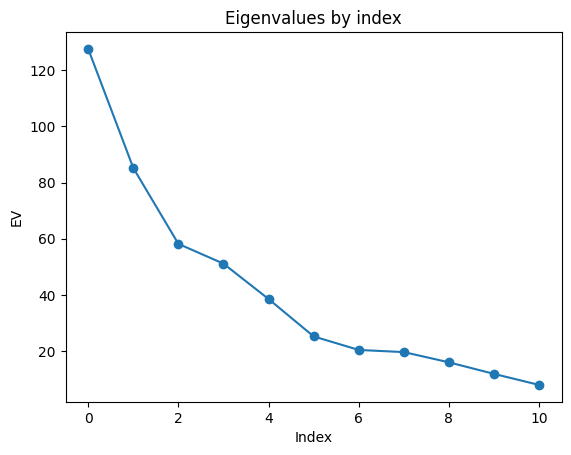

In [10]:
# Make a subkey sequence
#
keylst = coefs.makeKeys([2])
print("Keys=", keylst)

name = 'dark halo'
config = {name: (coefs, keylst, [])}

# This is the window length.  The largest meaningful length is half
# the size of the time series.  We'll choose that here but it *is*
# interesting to retry these analyses with different window lengths.

window = int(len(coefs.Times())/2)
npc = 10

print("Window={} PC number={}".format(window, npc))

ssa = pyEXP.mssa.expMSSA(config, window, npc)

ev = ssa.eigenvalues()

plt.plot(ev, 'o-')
plt.xlabel("Index")
plt.ylabel("EV")
plt.title("Eigenvalues by index")
plt.show()

### Next plot the principle components.

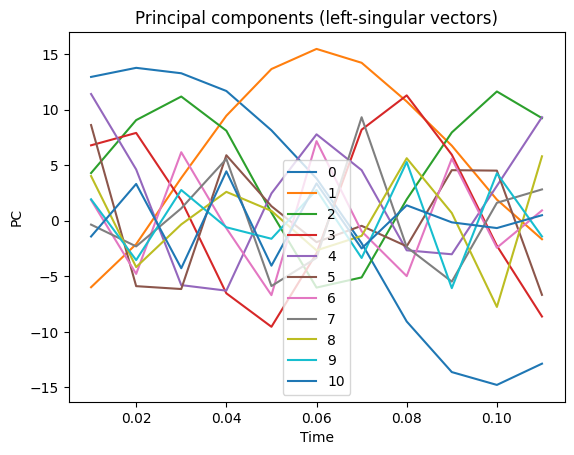

In [11]:
times = coefs.Times();
pc    = ssa.getPC();

rows, cols = pc.shape

for i in range(cols):
    plt.plot(times[0:rows], pc[:,i], '-', label="{:d}".format(i))

plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("Principal components (left-singular vectors)")
plt.show()

### Now try a reconstruction

In [12]:
coefs.zerodata() # <---replace with reconstructed
ssa.reconstruct([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
newdata = ssa.getReconstructed()
print('newdata is a', type(newdata))

newdata is a <class 'dict'>


### Compute the k-means analysis

The k-means partitions n vector observations into k clusters in which each observation belongs to the cluster with
the nearest centers while minimizing the variance within each cluster.  In this case, the vectors are the full
trajectory matrices and the distance is the distance between the trajectory matricies reconstructed from each
eigentriple from mSSA.  The distance used here is the Frobenius distance or matrix norm distance: the square root
of the sum of squares of all elements in the difference between two matrices.

Note: the k-means analysis will use the reconstructions from your last call to `reconstruct`.  In this notebook, that would be from the previous cell; the first 10 PCs.  The k-means initial cluster selection chooses every second PC by default.  This is a good choice for
time series representing quasi-periodic motion which generally have pairs of PCs representing the sinusoidal behavior.

The k-means analysis illustrates the clear patterns in the PCs seen in the plots above: the individual features occur in pairs, dominated by the first two pairs as seen in the eigenvalue plot.  This dominant pair is assigned id=0.  The next pair is assigned id=1.  The rest of the PCs are not particularly correlated and are lumped into id=0.

In [13]:
# Print k-means groups, allowing up to 6
#
id, dist, tol = ssa.kmeans(clusters=6)

# Print the results
print('{:<4s} | {:<4s} | {:<13s}'.format('PC', 'id', 'distance'))
print('{:<4s} | {:<4s} | {:<13s}'.format('----', '----', '--------'))
for k in range(len(id)):
    print('{:<4d} | {:<4d} | {:<13.6e}'.format(k, id[k], dist[k]))

PC   | id   | distance     
---- | ---- | --------     
0    | 0    | 6.243771e+00 
1    | 0    | 6.243771e+00 
2    | 1    | 4.312612e+00 
3    | 1    | 4.312612e+00 
4    | 2    | 0.000000e+00 
5    | 3    | 2.561358e+00 
6    | 3    | 2.561358e+00 
7    | 4    | 2.330193e+00 
8    | 4    | 2.342835e+00 
9    | 4    | 2.861371e+00 


In this case, k-means identifies 5 groups: 3 pairs and triple.  Compare this with the results from the w-correlation matrix in the next section...

You can see from the PCs themselves, that very few dynamical periods are available for analysis.  This simulation is not long enough for a highly signficant cluster analysis.

### Finally plot the w-correlation matrix
This is the sum of the w-correlation matrices for all channels.

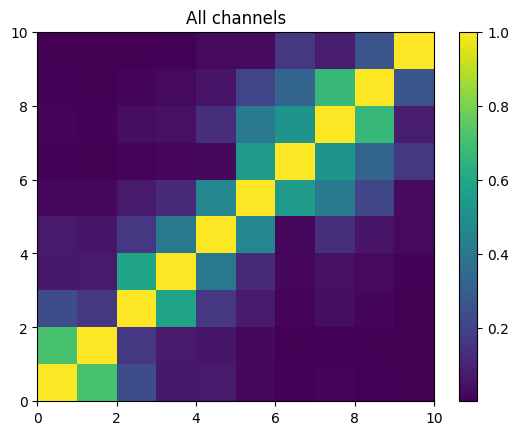

In [14]:
mat = ssa.wCorrAll()
x = plt.pcolormesh(mat)
plt.title("All channels")
plt.colorbar(x)
plt.show()

One can also look at individual channels.

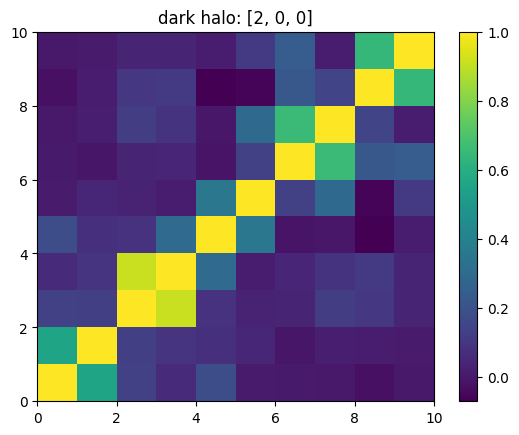

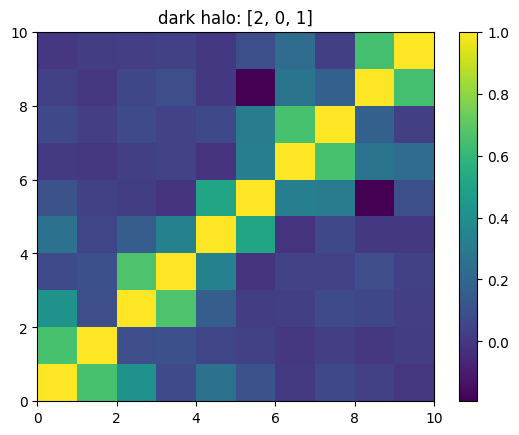

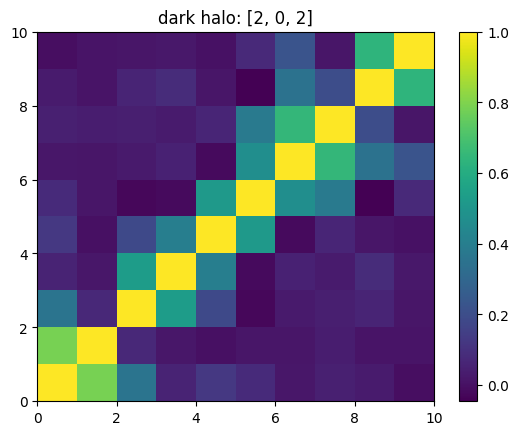

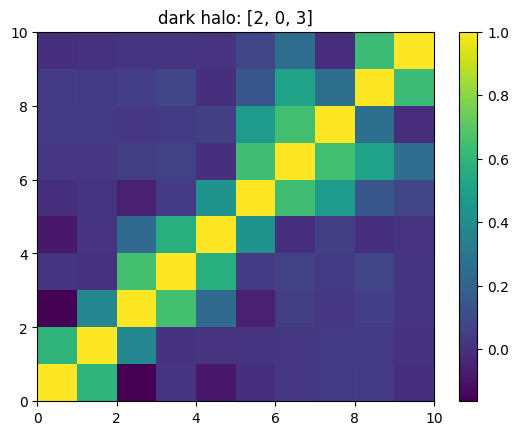

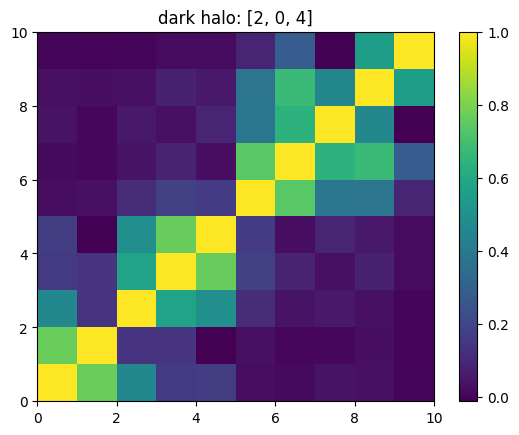

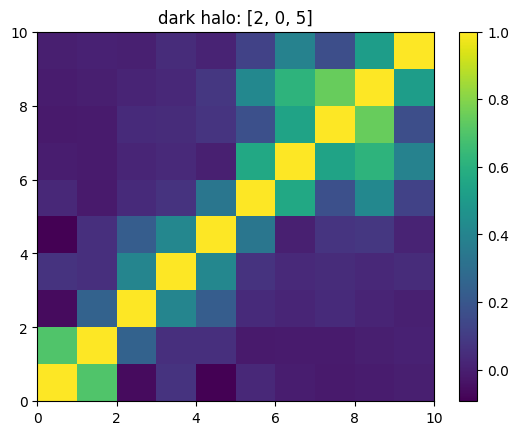

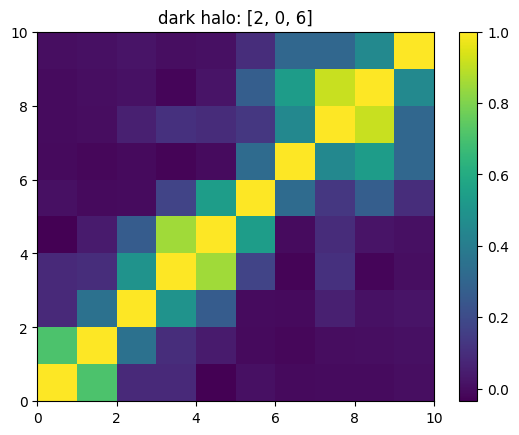

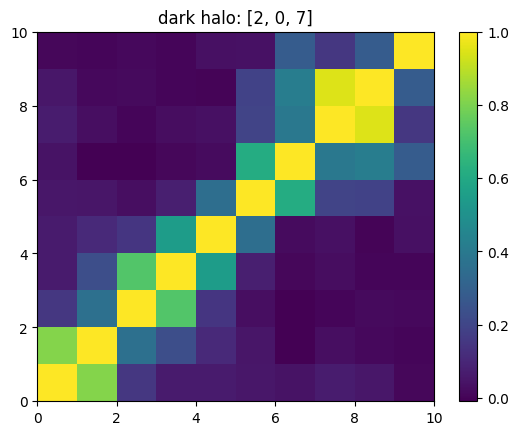

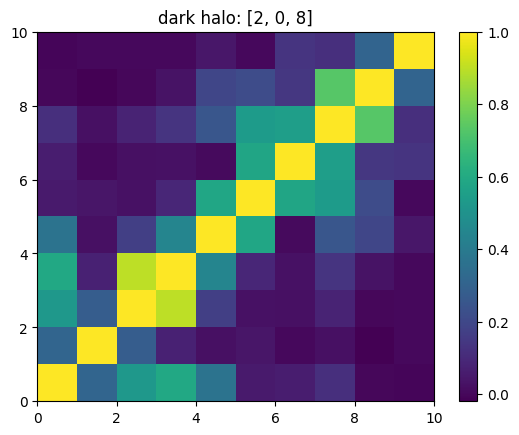

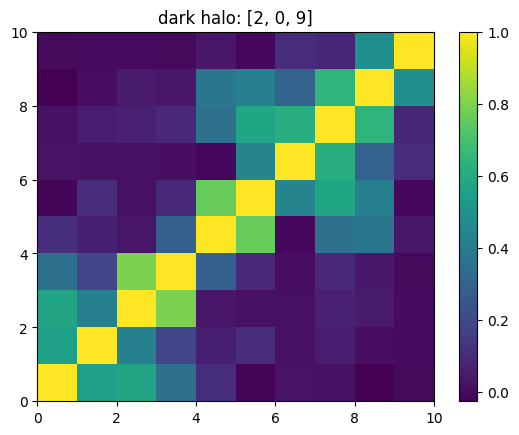

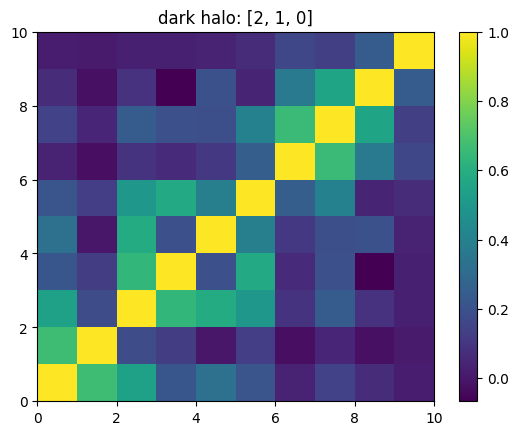

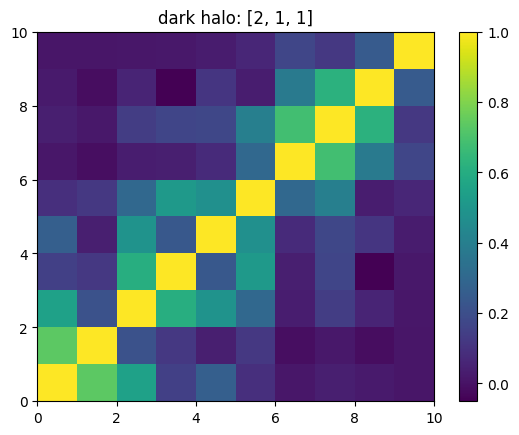

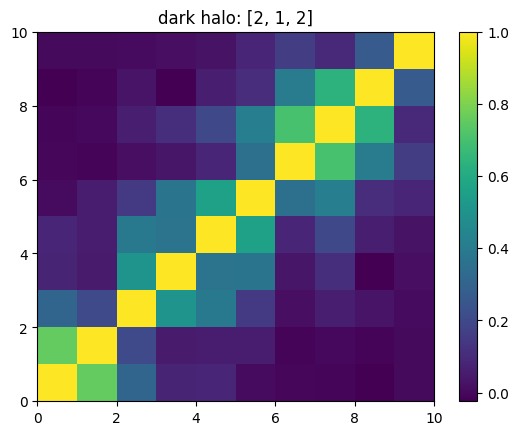

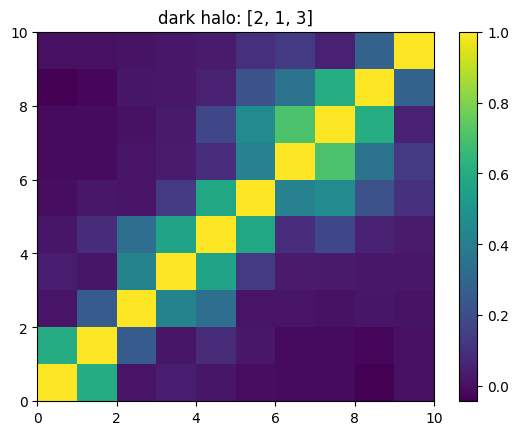

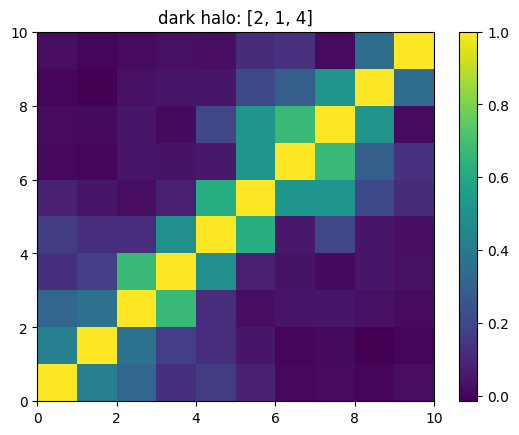

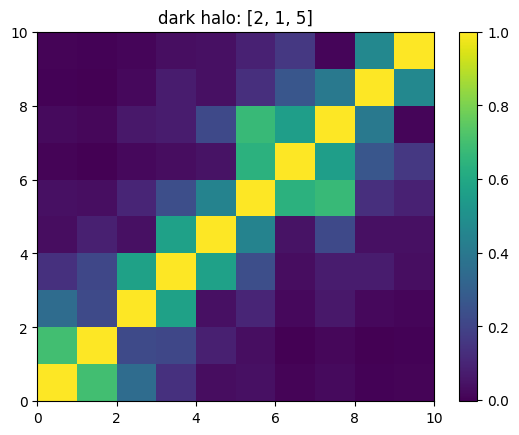

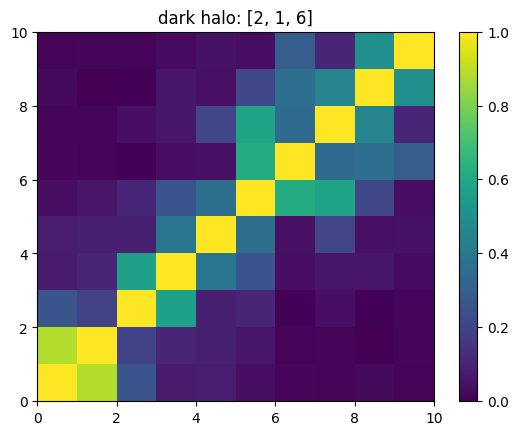

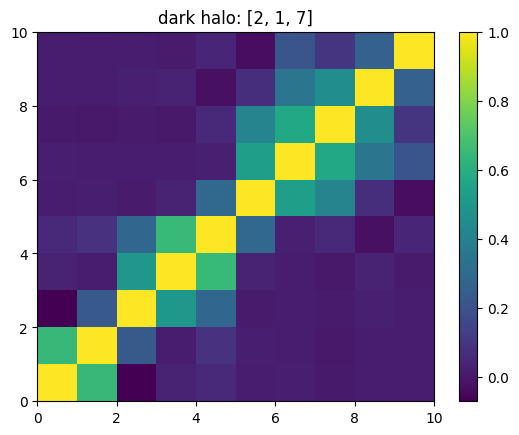

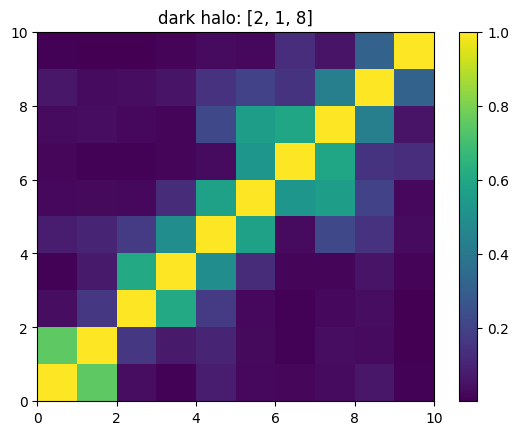

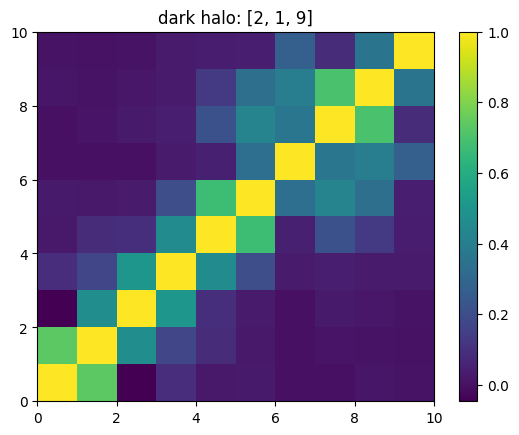

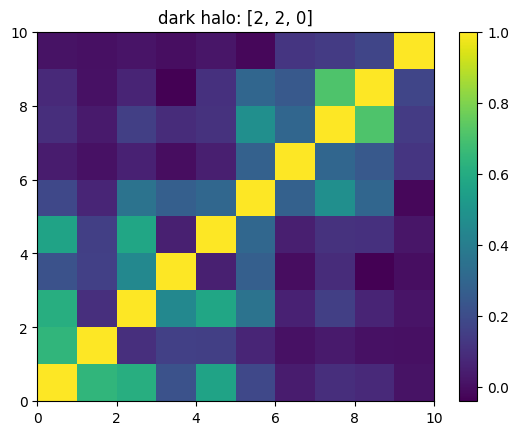

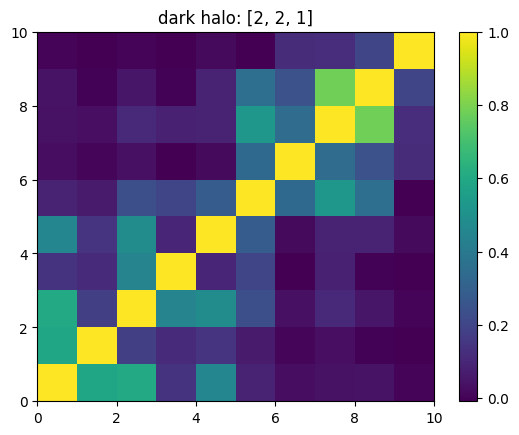

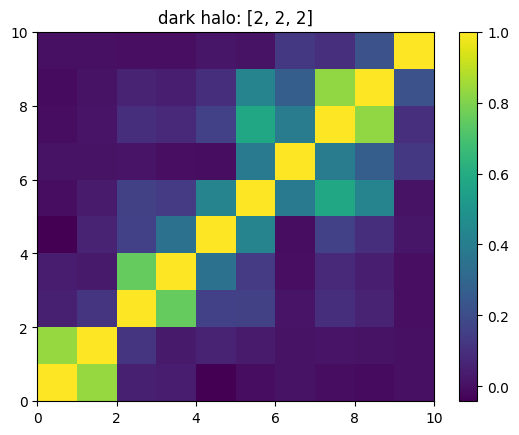

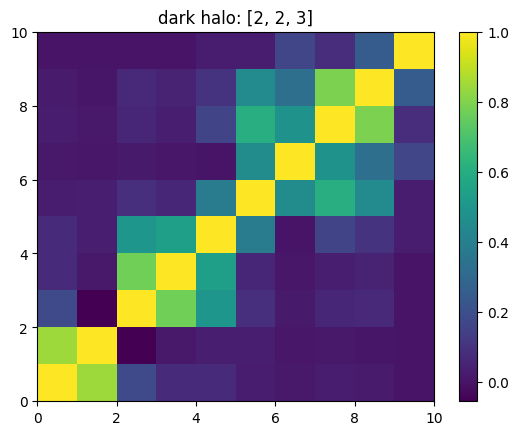

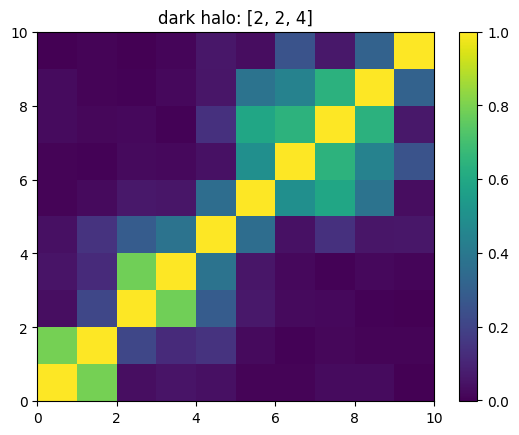

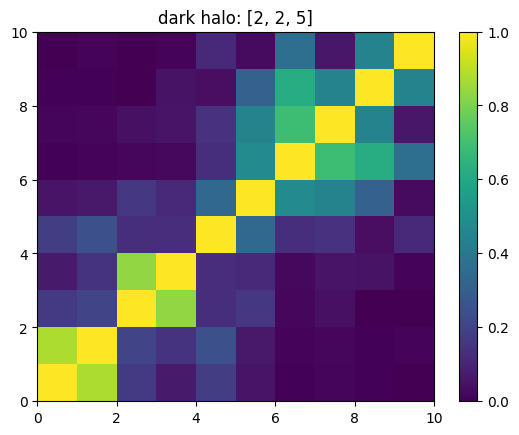

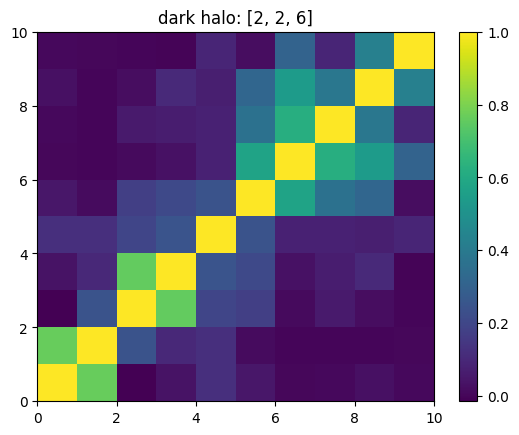

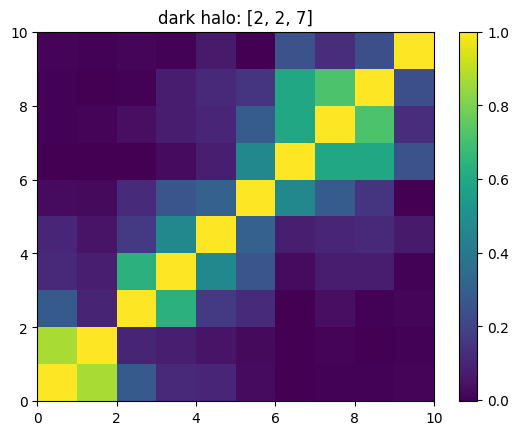

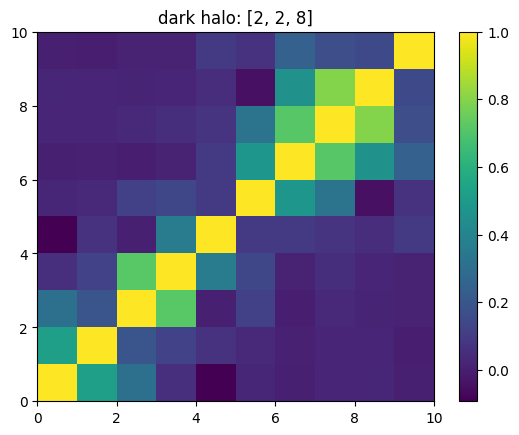

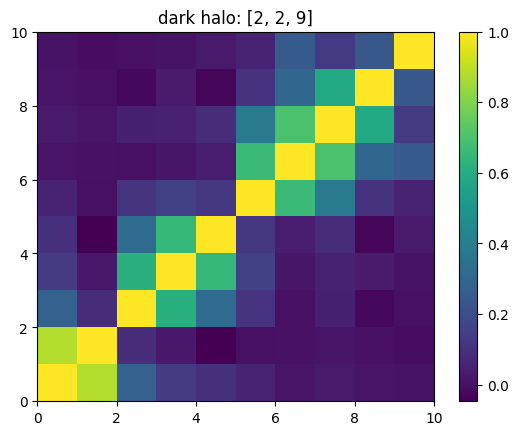

In [15]:
# Get and view the w-correlation matrices
# for each key individually
#
for k in keylst:
    mat = ssa.wCorr(name, k)
    # Plot it
    x = plt.pcolormesh(mat)
    plt.title('{}: {}'.format(name,k))
    plt.colorbar(x)
    plt.show()

***

## Where do you want to go next?

- [Return to Table of Contents](../README.ipynb)
- [Back to previous notebook](./Part1-Coefficients.ipynb)
- [Go to next notebook](../Basis/viewing%20a%20basis.ipynb)
